In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('../../input/dataset.csv')
# sub = pd.read_csv('../../input/submission.csv')
df.head()

,WindNumber,Time,WindSpeed,Power,RotorSpeed
0,1,2017/11/1 0:20,4.188333,65.750000,5.779167
1,1,2017/11/1 0:30,4.042500,120.700000,8.636500
2,1,2017/11/1 0:40,4.137368,135.157895,8.668421
3,1,2017/11/1 0:50,4.274737,157.315789,8.727895
4,1,2017/11/1 1:00,4.108947,129.894737,8.656842


In [3]:
res = df.loc[df['WindNumber'] == 7, :]
df1 = res.drop_duplicates()

res.shape[0], df1.shape[0]

(43324, 43152)

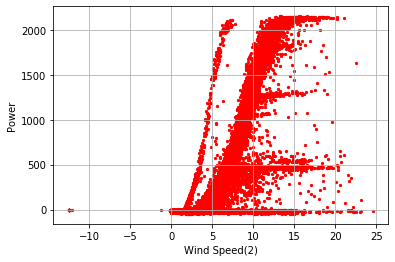

In [4]:
fig = plt.figure()
plt.scatter(df1['WindSpeed'], df1['Power'], s=5, c='r', cmap='viridis')
plt.xlabel('Wind Speed(2)')
plt.ylabel('Power')
plt.grid()
plt.show()

In [5]:
# fig = plt.figure(figsize=(20, 15))

# for i in range(1, 13):
#     plt.subplot(3, 4, i)
#     plt.scatter(df.loc[df['WindNumber'] == i, :]['WindSpeed'], df.loc[df['WindNumber'] == i, :]['Power'], s=5, c='r', cmap='viridis')
#     plt.xlabel('Wind Speed({})'.format(i))
#     plt.ylabel('Power')
# plt.show()

In [6]:
df1.head()

,WindNumber,Time,WindSpeed,Power,RotorSpeed
259466,7,2017/11/1 0:10,6.537000,290.500000,9.765000
259467,7,2017/11/1 0:20,6.920500,371.700000,10.358500
259468,7,2017/11/1 0:30,6.434000,309.650000,9.892500
259469,7,2017/11/1 0:40,5.262222,193.000000,8.907222
259470,7,2017/11/1 0:50,4.924444,180.722222,8.838889


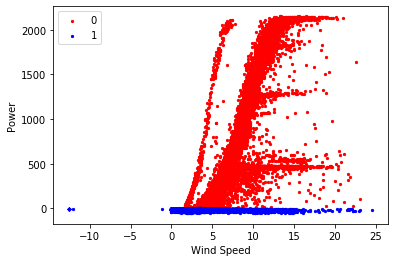

In [7]:
data0 = df1.copy()
data0['label_0'] = np.where(data0['Power'] < 0, 1, 0)

fig = plt.figure()
data_0 = data0.loc[data0['label_0'] == 0, :]
data_1 = data0.loc[data0['label_0'] == 1, :]
plt.scatter(data_0['WindSpeed'], data_0['Power'], s=5, c='r', cmap='viridis', label='0')
plt.scatter(data_1['WindSpeed'], data_1['Power'], s=5, c='b', cmap='viridis', label='1')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.legend(loc='best')
plt.show()

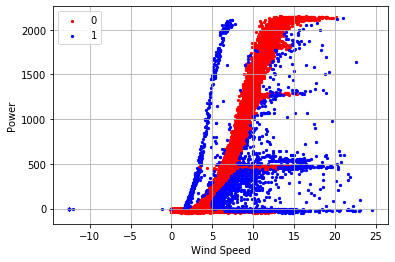

In [8]:
tmp = df1.sort_values(by='Power')
tmp['Power_bins'] = pd.cut(tmp['Power'], 90, labels=range(1, 91))

data1 = pd.DataFrame()
for i in range(1, 91):
    bin = tmp.loc[tmp['Power_bins'] == i, :]
    q1 = bin['WindSpeed'].quantile(0.25)
    q3 = bin['WindSpeed'].quantile(0.75)
    iqr = q3 - q1
    left = q1 - 1.5 * iqr
    right = q3 + 1.5 * iqr
    bin['label_1'] = bin['WindSpeed'].apply(lambda x: 1 if x < left or x > right else 0).astype(int)
    data1 = pd.concat([data1, bin], axis=0, ignore_index=True)
    data1.drop('Power_bins', axis=1, inplace=True)
    
fig = plt.figure()
ax = fig.gca()
data_0 = data1.loc[data1['label_1'] == 0, :]
data_1 = data1.loc[data1['label_1'] == 1, :]
plt.scatter(data_0['WindSpeed'], data_0['Power'], s=5, c='r', cmap='coolwarm', label='0')
plt.scatter(data_1['WindSpeed'], data_1['Power'], s=5, c='b', cmap='coolwarm', label='1')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.grid()
plt.legend(loc='best')
plt.show()

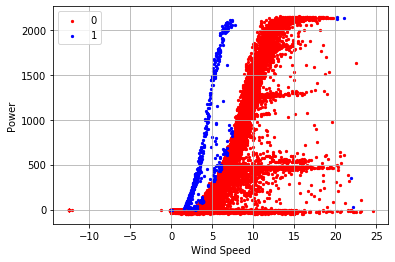

In [9]:
tmp = df1.sort_values(by='WindSpeed')
tmp['WindSpeed_bins'] = pd.cut(tmp['WindSpeed'], 50, labels=range(1, 51))

data2 = pd.DataFrame()
for i in range(1, 51):
    bin = tmp.loc[tmp['WindSpeed_bins'] == i, :]
    q1 = bin['Power'].quantile(0.25)
    q3 = bin['Power'].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    bin['label_2'] = bin['Power'].apply(lambda x: 1 if x > high else 0).astype(int)
    data2 = pd.concat([data2, bin], axis=0, ignore_index=True)
    data2.drop('WindSpeed_bins', axis=1, inplace=True)

fig = plt.figure()
data_0 = data2.loc[data2['label_2'] == 0, :]
data_1 = data2.loc[data2['label_2'] == 1, :]
plt.scatter(data_0['WindSpeed'], data_0['Power'], s=5, c='r', cmap='viridis', label='0')
plt.scatter(data_1['WindSpeed'], data_1['Power'], s=5, c='b', cmap='viridis', label='1')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.grid()
plt.legend(loc='best')
plt.show()

In [10]:
data = pd.merge(data0, data1, on=['WindNumber', 'Time', 'WindSpeed', 'Power', 'RotorSpeed'], how='inner')
data = pd.merge(data, data2, on=['WindNumber', 'Time', 'WindSpeed', 'Power', 'RotorSpeed'], how='inner')
data['label'] = data.apply(lambda x: 1 if x['label_0'] == 1 or x['label_1'] == 1 or x['label_2'] == 1 else 0, axis=1)
data.drop(['label_0', 'label_1', 'label_2'], axis=1, inplace=True)
data.head()

,WindNumber,Time,WindSpeed,Power,RotorSpeed,label
0,7,2017/11/1 0:10,6.537000,290.500000,9.765000,0
1,7,2017/11/1 0:20,6.920500,371.700000,10.358500,0
2,7,2017/11/1 0:30,6.434000,309.650000,9.892500,0
3,7,2017/11/1 0:40,5.262222,193.000000,8.907222,0
4,7,2017/11/1 0:50,4.924444,180.722222,8.838889,0


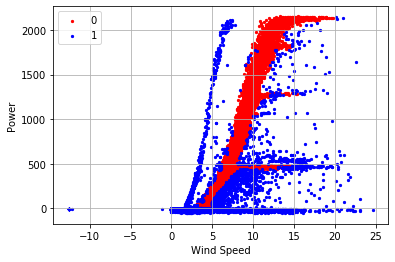

In [11]:
fig = plt.figure()
data_0 = data.loc[data['label'] == 0, :]
data_1 = data.loc[data['label'] == 1, :]
plt.scatter(data_0['WindSpeed'], data_0['Power'], s=5, c='r', cmap='viridis', label='0')
plt.scatter(data_1['WindSpeed'], data_1['Power'], s=5, c='b', cmap='viridis', label='1')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.grid()
plt.legend(loc='best')
plt.show()

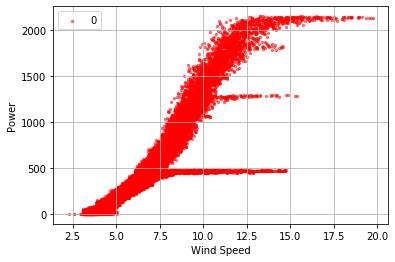

In [12]:
plt.scatter(data_0['WindSpeed'], data_0['Power'], s=5, c='r', alpha=0.5, cmap='viridis', label='0')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.grid()
plt.legend(loc='best')
plt.show()

2.269 19.741


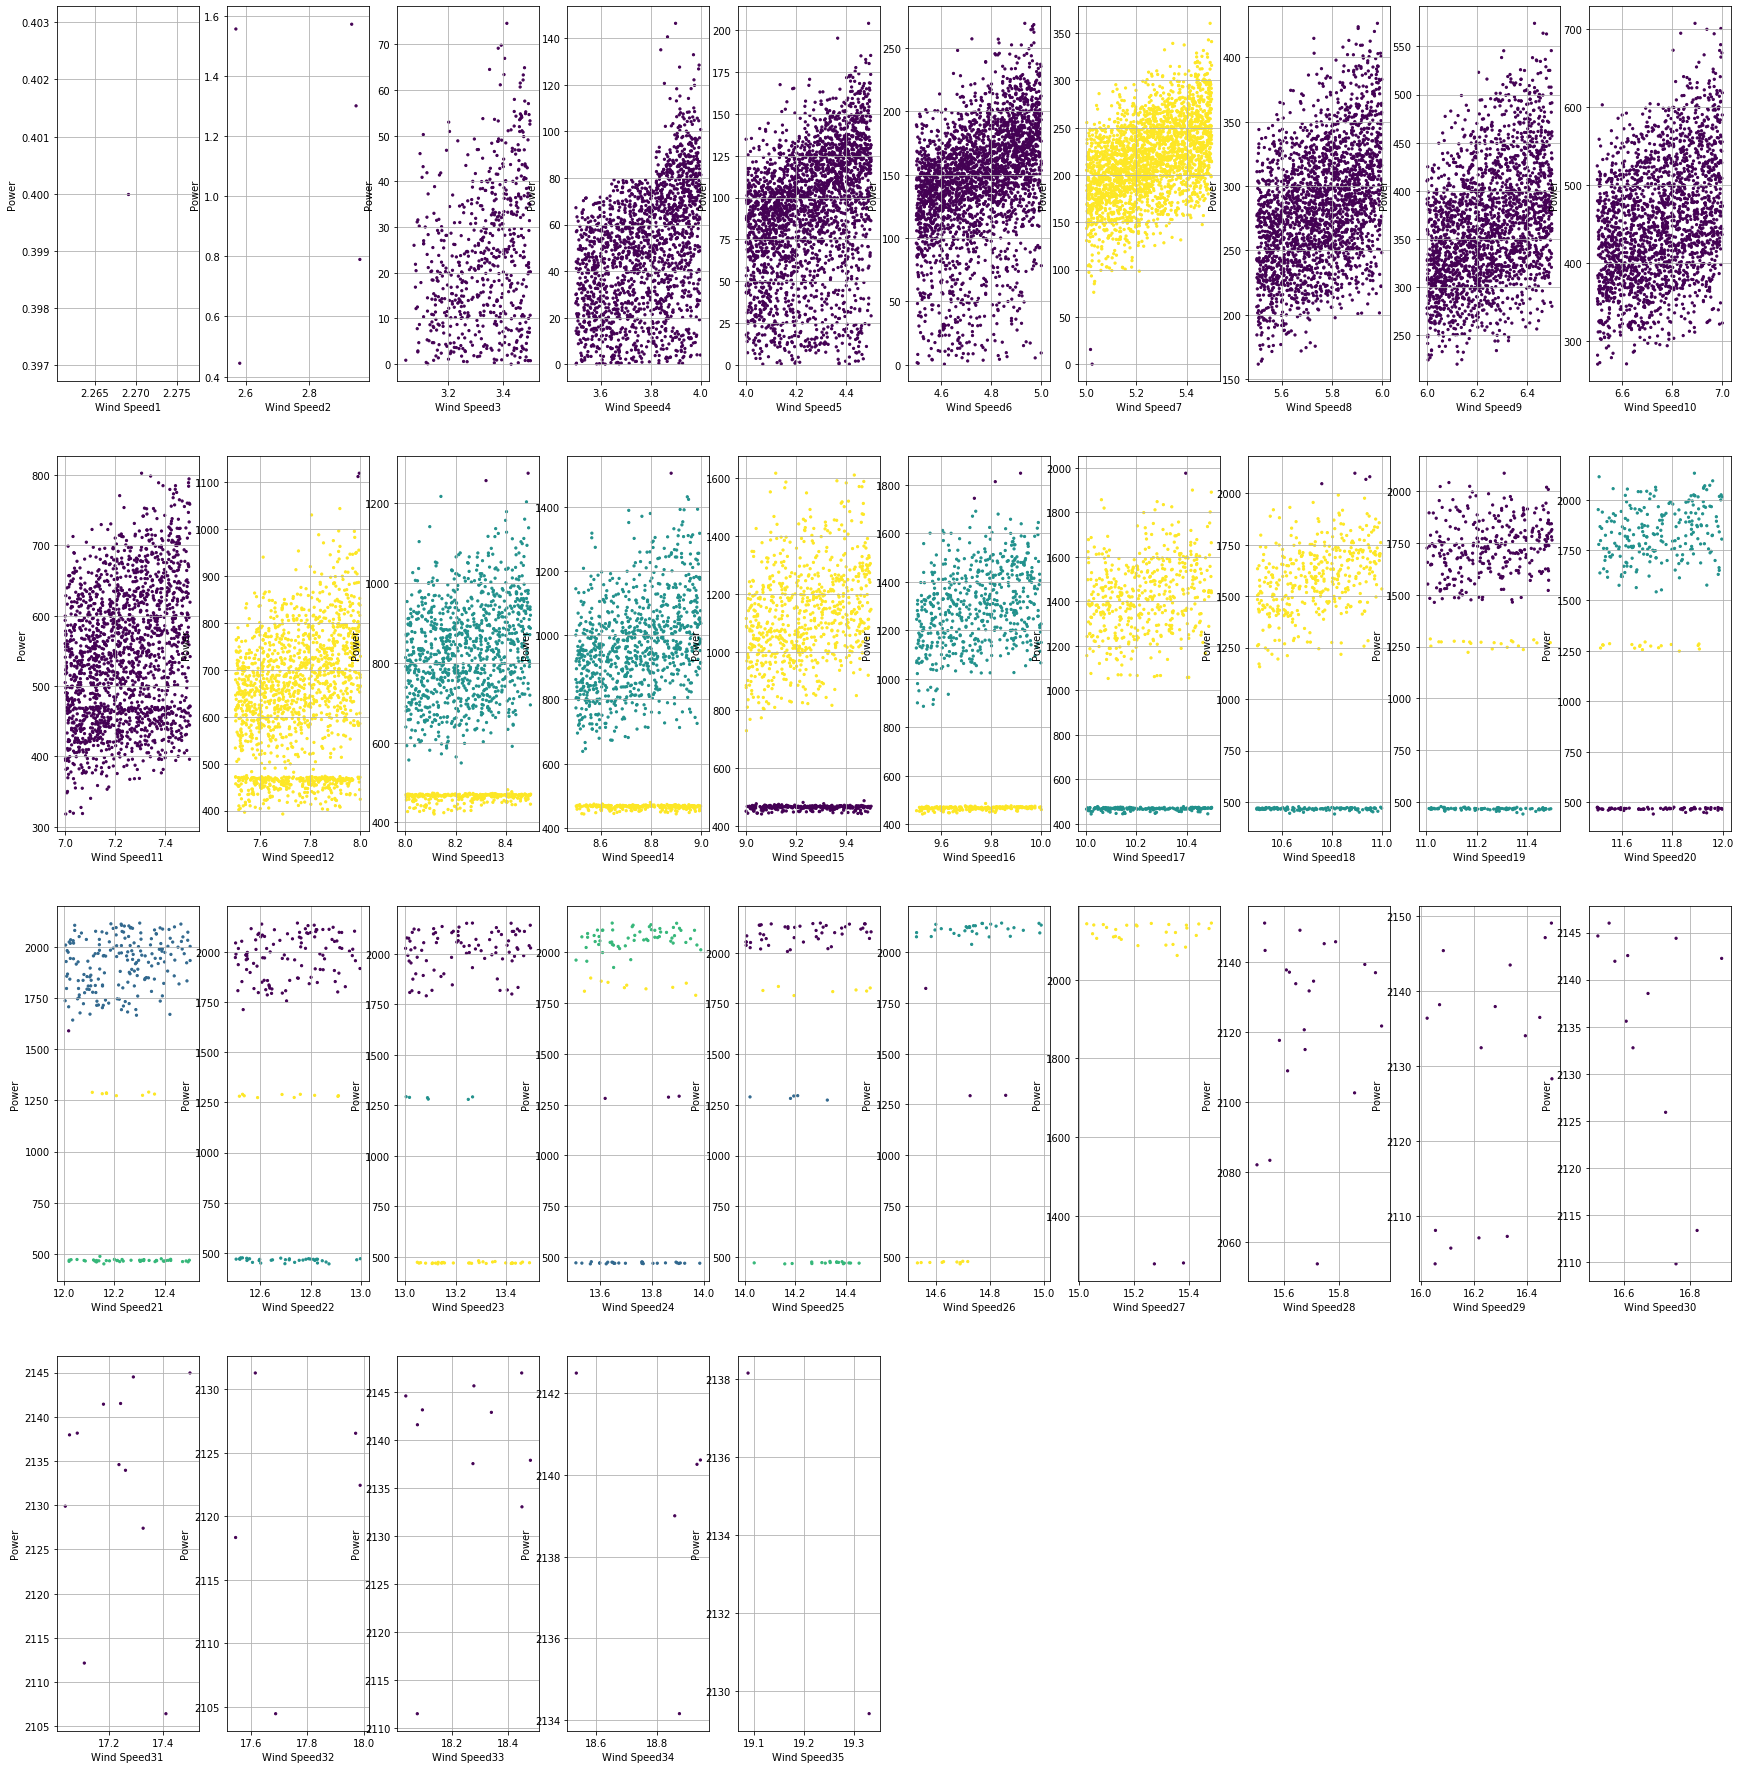

In [13]:
db_data = data_0.drop('label', axis=1).sort_values(by='WindSpeed').copy()
print(db_data['WindSpeed'].min(), db_data['WindSpeed'].max())
db_data['WindSpeed_bins'] = pd.cut(db_data['WindSpeed'], bins=list(np.arange(2, 20, 0.5)), labels=range(1, 36))

data3 = pd.DataFrame()
plt.figure(figsize=(30, 40))
for i in range(1, 36):
    # print('--------{}---------'.format(i))
    bin = db_data.loc[db_data['WindSpeed_bins'] == i, :]
    model = DBSCAN(eps=50, min_samples=5).fit(bin[['WindSpeed', 'Power']])
    # print('labels', i, np.unique(model.labels_))
    bin['label_3'] = model.labels_
    plt.subplot(5, 10, i)
    plt.scatter(bin['WindSpeed'], bin['Power'], s=5, c=bin['label_3'], cmap='viridis')
    plt.xlabel('Wind Speed{}'.format(i))
    plt.ylabel('Power')
    plt.grid()
    data3 = pd.concat([data3, bin], axis=0, ignore_index=True)
plt.show()

2.269 19.741


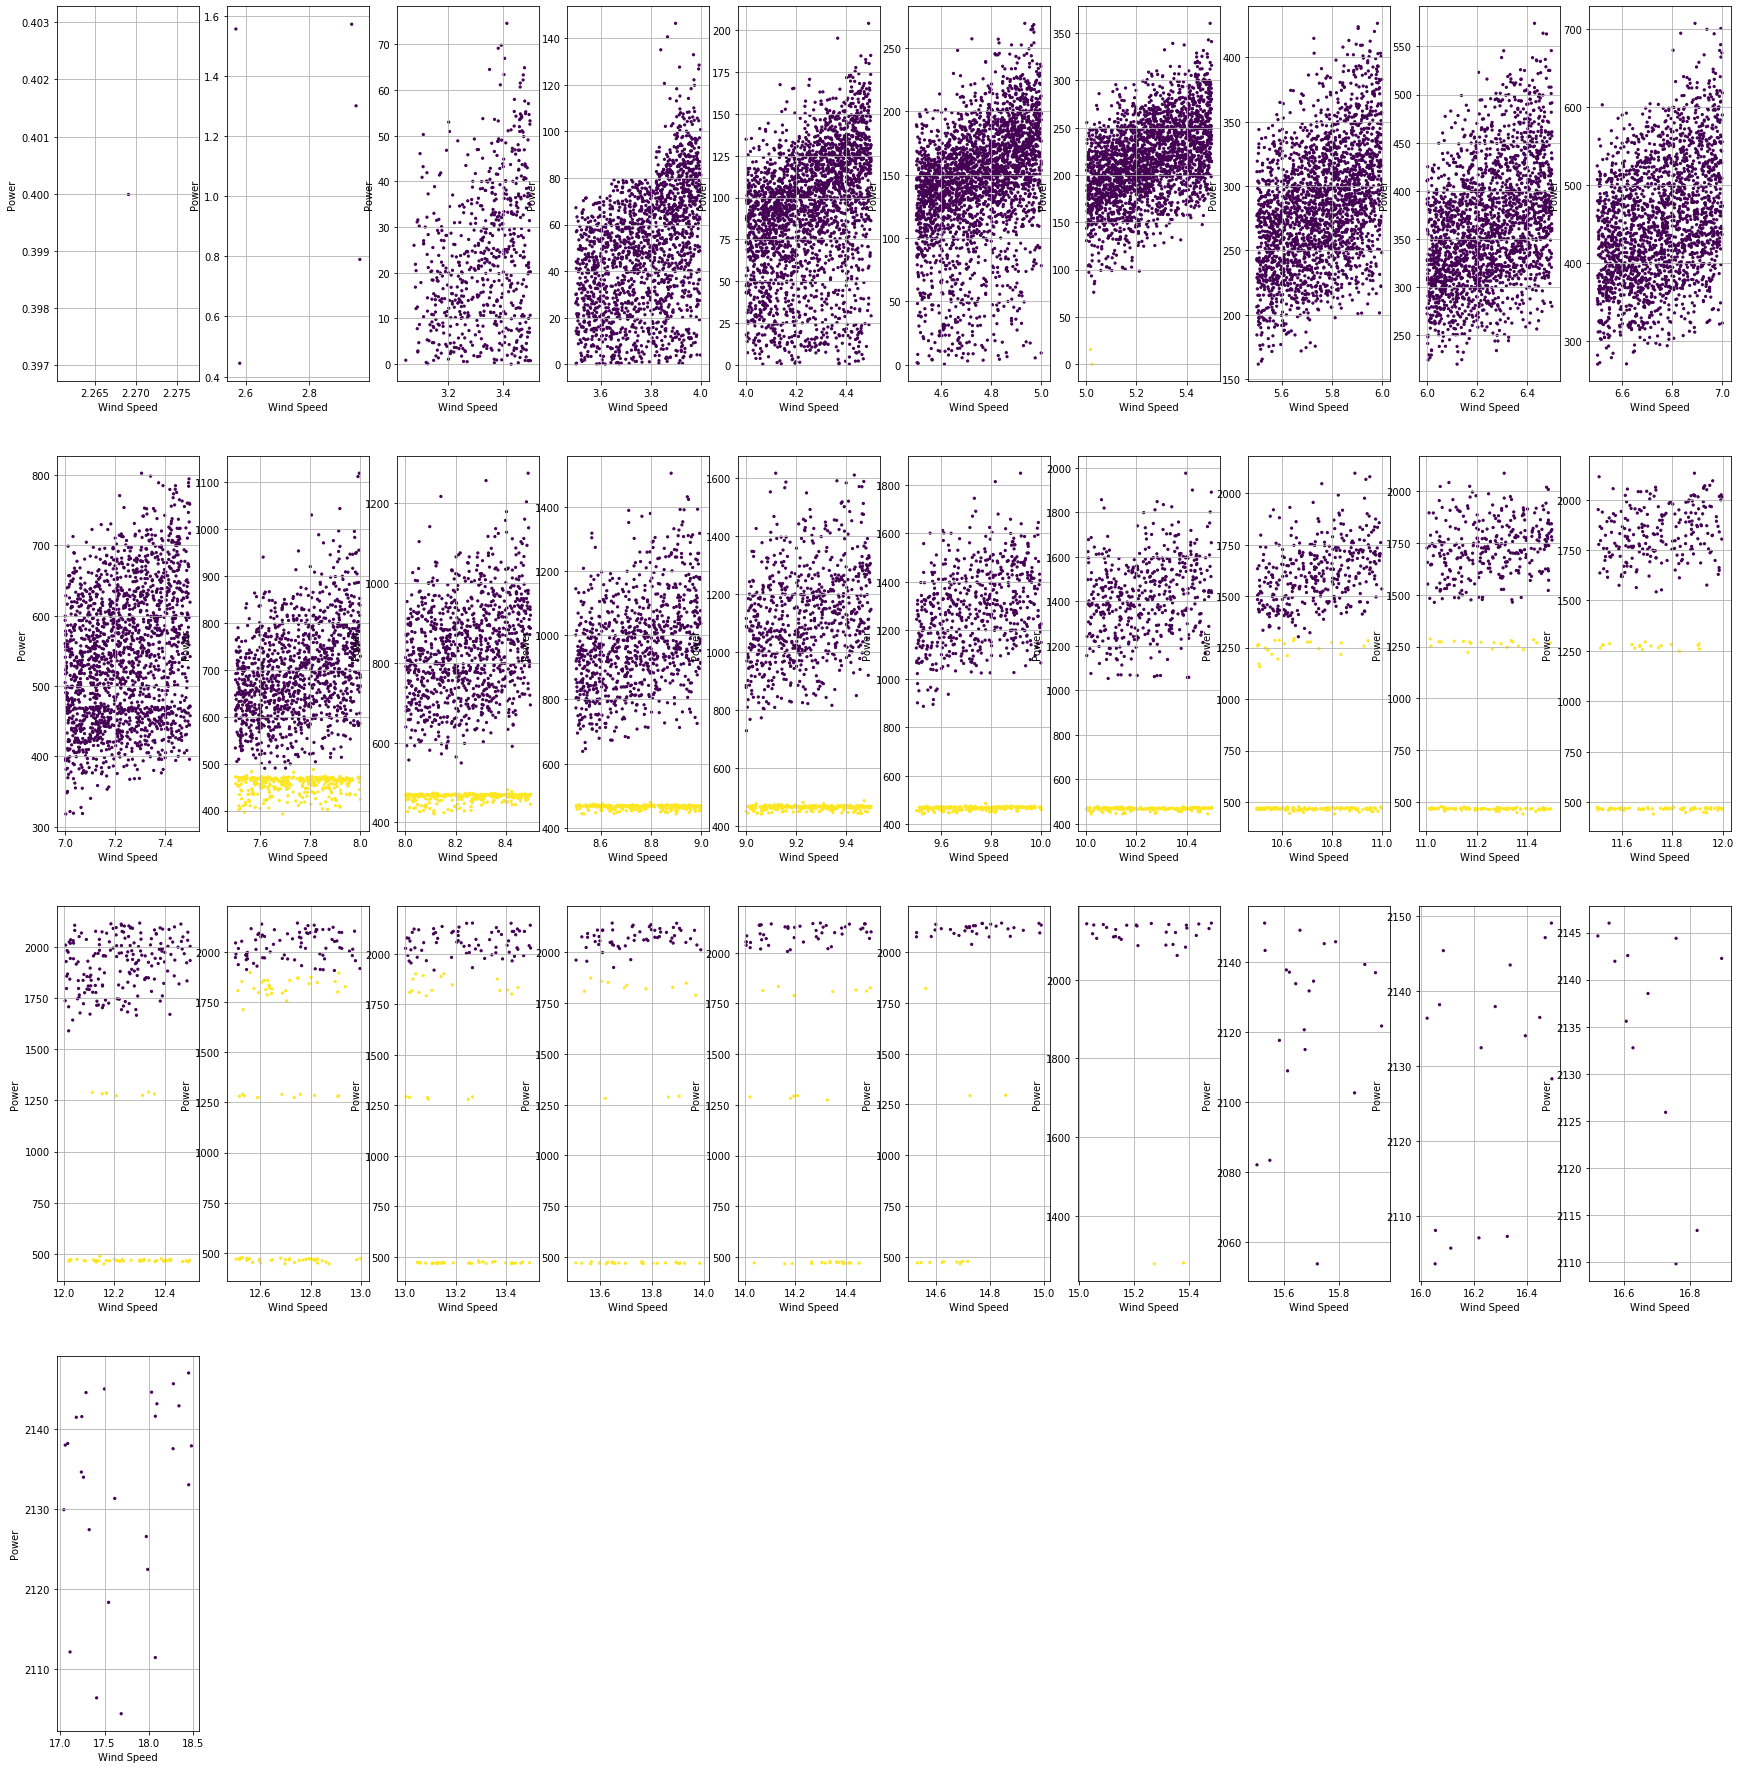

In [14]:
db_data = data_0.drop('label', axis=1).sort_values(by='WindSpeed').copy()
print(db_data['WindSpeed'].min(), db_data['WindSpeed'].max())
db_data['WindSpeed_bins'] = pd.cut(db_data['WindSpeed'], bins=list(np.arange(2, 17, 0.5))+[17.0, 18.5], labels=range(1, 32))

data3 = pd.DataFrame()
plt.figure(figsize=(30, 40))
for i in range(1, 32):
    # print('--------{}---------'.format(i))
    bin = db_data.loc[db_data['WindSpeed_bins'] == i, :]
    model = DBSCAN(eps=50, min_samples=5).fit(bin[['WindSpeed', 'Power']])
    # print('labels', i, np.unique(model.labels_))
    if i in [7]:
        bin['label_3'] = bin['Power'].apply(lambda x: 1 if x < 50 else 0)
    elif i in range(12, 17):
        bin['label_3'] = bin['Power'].apply(lambda x: 1 if x < 490 else 0)
    elif i in [17]:
        bin['label_3'] = bin['Power'].apply(lambda x: 1 if x < 800 else 0)
    elif i in range(18, 22):
        bin['label_3'] = bin['Power'].apply(lambda x: 1 if x < 1300 else 0)
    elif i in range(22, 28):
        bin['label_3'] = bin['Power'].apply(lambda x: 1 if x < 1900 else 0)
    else:
        bin['label_3'] = 0
    plt.subplot(5, 10, i)
    plt.scatter(bin['WindSpeed'], bin['Power'], s=5, c=bin['label_3'], cmap='viridis')
    plt.xlabel('Wind Speed')
    plt.ylabel('Power')
    plt.grid()
    data3 = pd.concat([data3, bin], axis=0, ignore_index=True)
plt.show()

In [15]:
data = pd.merge(data, data3, on=['WindNumber', 'Time', 'WindSpeed', 'Power', 'RotorSpeed'], how='left')
data['label'] = data.apply(lambda x: 1 if x['label'] == 1 or x['label_3'] == 1 else 0, axis=1)
data.drop(['label_3'], axis=1, inplace=True)
data.head()

,WindNumber,Time,WindSpeed,Power,RotorSpeed,label,WindSpeed_bins
0,7,2017/11/1 0:10,6.537000,290.500000,9.765000,0,10
1,7,2017/11/1 0:20,6.920500,371.700000,10.358500,0,10
2,7,2017/11/1 0:30,6.434000,309.650000,9.892500,0,9
3,7,2017/11/1 0:40,5.262222,193.000000,8.907222,0,7
4,7,2017/11/1 0:50,4.924444,180.722222,8.838889,0,6


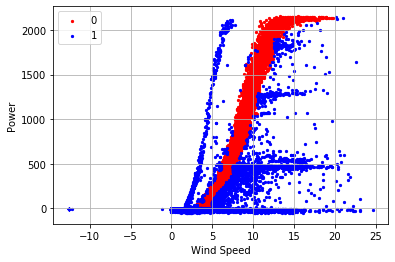

In [16]:
fig = plt.figure()
data_0 = data.loc[data['label'] == 0, :]
data_1 = data.loc[data['label'] == 1, :]
plt.scatter(data_0['WindSpeed'], data_0['Power'], s=5, c='r', cmap='viridis', label='0')
plt.scatter(data_1['WindSpeed'], data_1['Power'], s=5, c='b', cmap='viridis', label='1')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.grid()
plt.legend(loc='best')
plt.show()

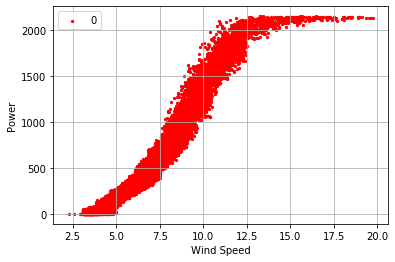

In [17]:
fig = plt.figure()
plt.scatter(data_0['WindSpeed'], data_0['Power'], s=5, c='r', cmap='viridis', label='0')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.grid()
plt.legend(loc='best')
plt.show()

In [18]:
res = res.merge(data, on=['WindNumber', 'Time', 'WindSpeed', 'Power', 'RotorSpeed'], how='left')
res[['WindNumber', 'Time', 'label']].to_csv('WindNumber7.csv', index=False)
res.shape[0]

43324